# Tutorial demonstrating verification of v1 SOI index against jra55

#### Import pyLatte package

In [1]:
from pylatte import utils
from pylatte import verif

#### Currently, the following packages are required to load the data - this process will be replaced by the CAFE cookbook

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import warnings    
warnings.filterwarnings("ignore")

# Jupyter specific -----
%matplotlib inline

#### The pyLatte package is constructed around the xarray Python package. This is particularly useful for verification computations which require large numbers of samples (different model runs) to converge. 

#### The approach here is to generate very large xarray objects that reference all data required for the verification, but do not store the data in memory. Operations are performed on these xarray objects out-of-memory. When it is necessary to perform a compute (e.g. to produce a plot), this is distributed over multiple processors using the dask Python package.

# Initialise dask (currently not working on vm31)

In [3]:
# import dask
# import distributed
# client = distributed.Client(local_dir='/tmp/squ027-dask-worker-space', n_workers=4)
# client

# Construct xarray objects for forecasts and observations

#### (The CAFE cookbook will replace these code blocks)

In [4]:
# Resampling details -----
resample_freq = '1MS' # Must be '1MS' for monthly
resample_method = 'sum'

# Location of forecast data -----
fcst_folder = '/OSM/CBR/OA_DCFP/data/model_output/CAFE/forecasts/v1/'
fcst_filename = 'atmos_daily*'

# Location of observation data -----
obsv_folder = '/OSM/CBR/OA_DCFP/data/observations/jra55/isobaric/002_prmsl/'
obsv_filename = 'anl_surf125.002_prmsl.'

In [5]:
# Initialization dates (takes approximately 1 min 30 sec per date) -----
init_dates = pd.date_range('2/2002','3/2002' , freq='1MS')  # Must be '1MS' for monthly

# Ensembles to include -----
ensembles = range(1,12)

# Forecast length -----
FCST_LENGTH = 2 # years
no_leap = 2001
n_incr = len(pd.date_range('1/1/' + str(no_leap),
                           '12/1/' + str(no_leap+FCST_LENGTH-1),
                           freq=resample_freq)) # number of lead_time increments
lead_times = range(1,n_incr+1)

### Construct forecasts xarray object

In [6]:
# import pdb, traceback, sys

# ==================================================
# Initialize xarray object for first init_date -----
# ==================================================
with utils.timer():
    print(f'Gathering data for forecast started on {init_dates[0].month}-{init_dates[0].year}...')
    
    ds_fcst = xr.open_mfdataset(fcst_folder + 
                                '/yr' + str(init_dates[0].year) + 
                                '/mn' + str(init_dates[0].month) + 
                                '/OUTPUT.' + str(ensembles[0]) + 
                                '/' + fcst_filename, autoclose=True)
    ds_fcst.coords['ensemble'] = ensembles[0]

    for ensemble in ensembles[1:]:
        ds_temp = xr.open_mfdataset(fcst_folder + 
                                    '/yr' + str(init_dates[0].year) + 
                                    '/mn' + str(init_dates[0].month) + 
                                    '/OUTPUT.' + str(ensemble) + 
                                    '/' + fcst_filename, autoclose=True)
        # Concatenate along 'ensemble' dimension/coordinate -----
        ds_temp.coords['ensemble'] = ensemble
        ds_fcst = xr.concat([ds_fcst, ds_temp],'ensemble')

    # Resample to desired frequency and resave time as lead time -----
    ds_fcst = ds_fcst.resample(freq=resample_freq, dim='time', how=resample_method) \
                               .isel(time = range(len(lead_times)))
    ds_fcst = ds_fcst.rename({'time' : 'lead_time'})
    ds_fcst['lead_time'] = lead_times

    # Initialize 'init_date' coordinate -----
    ds_fcst.coords['init_date'] = init_dates[0]
    ds_fcst = ds_fcst.expand_dims('init_date')
    
# ==============================================
# Loop over remaining initialization dates -----
# ==============================================
for init_date in init_dates[1:]:
    with utils.timer():
        year = init_date.year
        month = init_date.month
        print(f'Gathering data for forecast started on {month}-{year}...')

        # There is a bug in xarray that causes an 'invalid type promotion' sometimes when concatenating 
        # The following while loop provides a work-around 
        more_ensembles = True
        first_chunk = True
        current_ensemble = 1

        while more_ensembles:
            try:
                # Initialize xarray object for first ensemble -----
                ds_temp1 = xr.open_mfdataset(fcst_folder + 
                                             '/yr' + str(year) + 
                                             '/mn' + str(month) + 
                                             '/OUTPUT.' + str(ensembles[current_ensemble-1]) + 
                                             '/' + fcst_filename, autoclose=True)
                ds_temp1.coords['ensemble'] = ensembles[current_ensemble-1]

                for ensemble in ensembles[current_ensemble:]:
                    ds_temp2 = xr.open_mfdataset(fcst_folder + 
                                                '/yr' + str(year) + 
                                                '/mn' + str(month) + 
                                                '/OUTPUT.' + str(ensemble) + 
                                                '/' + fcst_filename, autoclose=True)
                    # Concatenate along 'ensemble' dimension/coordinate -----
                    ds_temp2.coords['ensemble'] = ensemble
                    ds_temp1 = xr.concat([ds_temp1, ds_temp2],'ensemble')

                # try:
                if first_chunk:
                    ds_chunk = ds_temp1
                else:
                    ds_chunk = xr.concat([ds_chunk, ds_temp1],'ensemble')
                # except:
                #     type, value, tb = sys.exc_info()
                #     traceback.print_exc()
                #     pdb.post_mortem(tb)

                more_ensembles = False
            except TypeError:
                if first_chunk:
                    ds_chunk = ds_temp1
                    first_chunk = False
                else:
                    ds_chunk = xr.concat([ds_chunk, ds_temp1],'ensemble')
                current_ensemble = ensemble

        # Resample to desired frequency and resave time as lead time -----
        ds_chunk = ds_chunk.resample(freq=resample_freq, dim='time', how=resample_method) \
                           .isel(time = range(len(lead_times)))
        ds_chunk = ds_chunk.rename({'time' : 'lead_time'})
        ds_chunk['lead_time'] = lead_times

        # Concaneate along 'init_date' dimension/coordinate -----
        ds_chunk.coords['init_date'] = init_date
        ds_fcst = xr.concat([ds_fcst, ds_chunk],'init_date')

Gathering data for forecast started on 2-2002...
   Elapsed: 5.901398658752441 sec
Gathering data for forecast started on 3-2002...
   Elapsed: 5.839343070983887 sec


#### Rechunk

In [7]:
with utils.timer():
    # Rechunk for chunksizes of at least 1,000,000 elements -----
    ds_fcst = ds_fcst.chunk(chunks={'ensemble' : len(ensembles), 'lead_time' : len(lead_times)})

    # Overwrite init_dates in case didn't fully load -----
    init_dates = ds_fcst.init_date.values

   Elapsed: 0.45969676971435547 sec


### Construct observations xarray object

In [8]:
fcst_years = [pd.to_datetime(init_dates).year]
fcst_year_min = min(fcst_years)[0]
fcst_year_max = max(fcst_years)[-1] + FCST_LENGTH

# ===================================================
# Only load years for which forecast data exist -----
# ===================================================
with utils.timer():
    print(f'Gathering data for observations...')
    
    ds_temp1 = xr.open_mfdataset(obsv_folder + obsv_filename + str(fcst_year_min) + '*', 
                                 autoclose=True)
    for year_to_load in range(fcst_year_min+1,fcst_year_max+1):
        ds_temp2 = xr.open_mfdataset(obsv_folder + obsv_filename + str(year_to_load) + '*', 
                                     autoclose=True)
        ds_temp1 = xr.concat([ds_temp1, ds_temp2],'initial_time0_hours')

    # Standardize naming -----
    ds_temp1 = ds_temp1.rename({'initial_time0_hours':'time',
                                      'g0_lon_2':'lon',
                                      'g0_lat_1':'lat',
                                      'PRMSL_GDS0_MSL':'slp'})

    # Resample to desired frequency -----
    ds_temp1 = ds_temp1.resample(freq=resample_freq, dim='time', how=resample_method)
    
    # ===============================================
    # Stack to resemble ds_forecast coordinates -----
    # ===============================================
    # Initialize xarray object for first lead_time -----
    start_index = np.where(ds_temp1.time == np.datetime64(init_dates[0]))[0].item()
    ds_obsv = ds_temp1.isel(time=range(start_index, start_index+len(lead_times)))
    ds_obsv.coords['init_date'] = init_dates[0]
    ds_obsv = ds_obsv.expand_dims('init_date')
    ds_obsv = ds_obsv.rename({'time' : 'lead_time'})
    ds_obsv['lead_time'] = lead_times
    
    # Loop over remaining lead_time -----
    for init_date in init_dates[1:]:
        start_index = np.where(ds_temp1.time == np.datetime64(init_date))[0].item()
        ds_temp3 = ds_temp1.isel(time=range(start_index, start_index+len(lead_times)))

        # Concatenate along 'lead_time' dimension/coordinate -----
        ds_temp3 = ds_temp3.rename({'time' : 'lead_time'})
        ds_temp3['lead_time'] = lead_times
        ds_temp3.coords['init_date'] = init_date
        ds_obsv = xr.concat([ds_obsv, ds_temp3],'init_date') 

Gathering data for observations...
   Elapsed: 0.3043372631072998 sec


#### Rechunk

In [9]:
with utils.timer():
    # Rechunk for chunksizes of at least 1,000,000 elements -----
    ds_obsv = ds_obsv.chunk(chunks={'init_date' : len(init_dates)})

   Elapsed: 0.0036890506744384766 sec


# Compute the SOI index

#### Here defined simply as mslp Tahiti - Darwin

In [20]:
lat_Tahiti = 17.6509
lon_Tahiti = 149.4260

lat_Darwin = 12.4634
lon_Darwin = 130.8456

# Forecast -----
SOI_fcst = (utils.get_nearest_point(ds_fcst['slp'], lat_Tahiti, lon_Tahiti) - \
            utils.get_nearest_point(ds_fcst['slp'], lat_Darwin, lon_Darwin)).compute() * 100
    
# Observation -----
SOI_obsv = (utils.get_nearest_point(ds_obsv['slp'], lat_Tahiti, lon_Tahiti) - \
            utils.get_nearest_point(ds_obsv['slp'], lat_Darwin, lon_Darwin)).compute()

# Compute some skill metrics

## (Continuous) ranked probability score

In [35]:
# Specify bins for computation of cdf -----
bins = np.linspace(0,200,10)

# Compute ranked probability score -----
rps = verif.compute_rps(SOI_fcst, SOI_obsv, bins=bins, indep_dims='init_date', ensemble_dim='ensemble')

In [38]:
SOI_obsv

<xarray.DataArray 'slp' (init_date: 2, lead_time: 24)>
array([[  6568.75 ,  44125.   ,  21440.625,  26378.125,  38543.75 ,  14625.   ,
         -6228.125,    481.25 ,  -3278.125,  31906.25 ,  19059.375,  17496.875,
         20165.625,  21618.75 ,  40090.625,  28234.375,  32787.5  ,  35943.75 ,
         29734.375,  24750.   ,  23540.625,  38196.875,  24331.25 ,  28281.25 ],
       [ 44125.   ,  21440.625,  26378.125,  38543.75 ,  14625.   ,  -6228.125,
           481.25 ,  -3278.125,  31906.25 ,  19059.375,  17496.875,  20165.625,
         21618.75 ,  40090.625,  28234.375,  32787.5  ,  35943.75 ,  29734.375,
         24750.   ,  23540.625,  38196.875,  24331.25 ,  28281.25 ,  37884.375]])
Coordinates:
  * lead_time  (lead_time) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * init_date  (init_date) datetime64[ns] 2002-02-01 2002-03-01

   Elapsed: 0.022570133209228516 sec


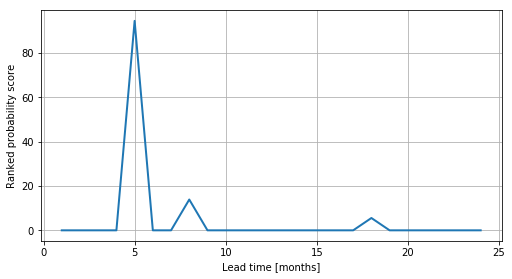

In [36]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot(rps['lead_time'],rps,linewidth=2)
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Ranked probability score');

## Reliability diagram

#### E.g. for the event of monthly rainfall over Tasmania being greater than 60 mm/month but less than 200 mm/month

In [ ]:
variable = 'precip'

event = '((> 60) and (< 200)) or (> 1000) or (= 500.0)' # for example

# Region of interest -----
region = (-44.0, -40.0, 144.0 , 148.0) # (lat_min,lat_max,lon_min,lon_max)

da_fcst = utils.calc_boxavg_latlon(ds_fcst[variable] * 60 * 60 * 24 / 998.2 * 1000, region)

# The jra55 precip data is saved with 3hr and 6hr forecasts as an additional dimension - deal with these -----
da_obsv = utils.calc_boxavg_latlon(1 / 8 * ds_obsv[variable].sum(dim='forecast_time1'), region)

#### Compute reliability as a function of lead time 

In [ ]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = verif.compute_likelihood(verif.did_event(da_fcst, event))
    obsv_logical = verif.did_event(da_obsv, event)

    # Compute the reliability -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    reliability = verif.compute_reliability(fcst_likelihood,obsv_logical,
                                            fcst_probabilities,indep_dims='init_date')

In [ ]:
with utils.timer():
    ncol = 4; nrow = int(np.ceil(len(lead_times)/ncol));
    fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

    for idx,ax in enumerate(axs.reshape(-1)): 
        ax.grid()
        ax.plot([0, 1],[0, 1],'k--')
        sample_clim = reliability['relative_freq'].isel(lead_time=idx, drop=True).mean()
        ax.plot([-1, 2],[sample_clim, sample_clim],'k--')
        ax.plot(reliability['forecast_probability'],
                reliability['relative_freq'].isel(lead_time=idx, drop=True),'r',linewidth=2)
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0.82,0.7,'mn '+str(idx+1))

        if idx % ncol == 0:
            ax.set_ylabel('Relative frequency')

        if idx / ncol >= nrow - 1:
            ax.set_xlabel('Forecast probability')

        fig = plt.gcf()
        box = ax.get_position()
        width = box.width
        height = box.height
        subpos = [0.05,0.65,0.3,0.3]
        inax_position  = ax.transAxes.transform(subpos[0:2])
        transFigure = fig.transFigure.inverted()
        infig_position = transFigure.transform(inax_position)    
        x = infig_position[0]
        y = infig_position[1]
        width *= subpos[2]
        height *= subpos[3] 
        subax = fig.add_axes([x,y,width,height])
        subax.yaxis.tick_right()
        subax.bar(reliability['forecast_probability'],reliability['fcst_number'].isel(lead_time=idx, drop=True),
                  width=reliability['forecast_probability'][1])

#### Compute reliability across all lead times

In [ ]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = verif.compute_likelihood(verif.did_event(da_fcst, event))
    obsv_logical = verif.did_event(da_obsv, event)

    # Compute the reliability -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    reliability = verif.compute_reliability(fcst_likelihood,obsv_logical,fcst_probabilities,
                                            indep_dims=['init_date','lead_time'])

In [ ]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,6))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot([0, 1],[0, 1],'k--')
    sample_clim = reliability['relative_freq'].mean()
    ax.plot([-1, 2],[sample_clim, sample_clim],'k--')
    ax.plot(reliability['forecast_probability'],reliability['relative_freq'],'r',linewidth=2)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('Forecast probability')
    ax.set_ylabel('Relative frequency');

    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    subpos = [0.05,0.65,0.3,0.3]
    inax_position  = ax.transAxes.transform(subpos[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= subpos[2]
    height *= subpos[3] 
    subax = fig.add_axes([x,y,width,height])
    subax.yaxis.tick_right()
    subax.bar(reliability['forecast_probability'],reliability['fcst_number'],
              width=reliability['forecast_probability'][1]);

## Brier score

#### E.g. for the event of monthly rainfall over Tasmania being greater than 100 mm/month

In [ ]:
variable = 'precip'

event = '> 100' # for example

# Region of interest -----
region = (-44.0, -40.0, 144.0 , 148.0) # (lat_min,lat_max,lon_min,lon_max)

da_fcst = utils.calc_boxavg_latlon(ds_fcst[variable] * 60 * 60 * 24 / 998.2 * 1000, region)

# The jra55 precip data is saved with 3hr and 6hr forecasts as an additional dimension - deal with these -----
da_obsv = utils.calc_boxavg_latlon(1 / 8 * ds_obsv[variable].sum(dim='forecast_time1'), region)

#### Compute Brier scores as a function of lead time

In [ ]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = verif.compute_likelihood(verif.did_event(da_fcst, event))
    obsv_logical = verif.did_event(da_obsv, event)

    # Compute the Brier score -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])-6)
    Brier = verif.compute_Brier_score(fcst_likelihood,obsv_logical,fcst_prob=fcst_probabilities,
                                      indep_dims='init_date')

In [ ]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot(Brier['lead_time'],Brier['Brier_reliability'],linewidth=1)
    ax.plot(Brier['lead_time'],Brier['Brier_resolution'],linewidth=1)
    ax.plot(Brier['lead_time'],Brier['Brier_uncertainty'],linewidth=1)
    ax.plot(Brier['lead_time'],Brier['Brier_total'],linewidth=2)
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Brier score')
    ax.legend();

## Relative operating characteristic

#### E.g. for the event of monthly rainfall over Tasmania being greater than 100 mm/month

In [ ]:
variable = 'precip'

event = '> 100' # for example

# Region of interest -----
region = (-44.0, -40.0, 144.0 , 148.0) # (lat_min,lat_max,lon_min,lon_max)

da_fcst = utils.calc_boxavg_latlon(ds_fcst[variable] * 60 * 60 * 24 / 998.2 * 1000, region)

# The jra55 precip data is saved with 3hr and 6hr forecasts as an additional dimension - deal with these -----
da_obsv = utils.calc_boxavg_latlon(1 / 8 * ds_obsv[variable].sum(dim='forecast_time1'), region)

#### Compute ROC diagrams as a function of lead time

In [ ]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = verif.compute_likelihood(verif.did_event(da_fcst, event))
    obsv_logical = verif.did_event(da_obsv, event)

    # Compute the roc -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    roc = verif.compute_roc(fcst_likelihood, obsv_logical, fcst_probabilities, 
                            indep_dims='init_date')

In [ ]:
with utils.timer():
    ncol = 4; nrow = int(np.ceil(len(lead_times)/ncol));
    fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

    for idx,ax in enumerate(axs.reshape(-1)): 
        ax.grid()
        ax.plot([-1, 2],[-1, 2],'k--')
        ax.plot(roc['false_alarm_rate'].isel(lead_time=idx, drop=True),
                roc['hit_rate'].isel(lead_time=idx, drop=True),'ro-',linewidth=2)
        ax.set_xlim(-0.02,1.02)
        ax.set_ylim(-0.02,1.02)
        ax.text(0.82,0.7,'mn '+str(idx+1))

        if idx % ncol == 0:
            ax.set_ylabel('Hit rate')

        if idx / ncol >= nrow - 1:
            ax.set_xlabel('False alarm rate')

#### Compute ROC diagram for all lead times

In [ ]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = verif.compute_likelihood(verif.did_event(da_fcst, event))
    obsv_logical = verif.did_event(da_obsv, event)

    # Compute the roc -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    roc = verif.compute_roc(fcst_likelihood, obsv_logical, fcst_probabilities, 
                            indep_dims=('init_date','lead_time'))

In [ ]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,6))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot([-1, 2],[-1, 2],'k--')
    ax.plot(roc['false_alarm_rate'],roc['hit_rate'],'ro-',linewidth=2)
    ax.set_xlim(-0.02,1.02)
    ax.set_ylim(-0.02,1.02)
    ax.set_xlabel('Hit rate')
    ax.set_ylabel('False alarm rate');

## Discrimination diagram

#### E.g. for the event of monthly rainfall over Tasmania being greater than 100 mm/month

In [ ]:
variable = 'precip'

event = '> 100' # for example

# Region of interest -----
region = (-44.0, -40.0, 144.0 , 148.0) # (lat_min,lat_max,lon_min,lon_max)

da_fcst = utils.calc_boxavg_latlon(ds_fcst[variable] * 60 * 60 * 24 / 998.2 * 1000, region)

# The jra55 precip data is saved with 3hr and 6hr forecasts as an additional dimension - deal with these -----
da_obsv = utils.calc_boxavg_latlon(1 / 8 * ds_obsv[variable].sum(dim='forecast_time1'), region)

#### Compute discrimination diagrams as a function of lead time

In [ ]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = verif.compute_likelihood(verif.did_event(da_fcst, event))
    obsv_logical = verif.did_event(da_obsv, event)

    # Compute the discrimination -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    discrimination = verif.compute_discrimination(fcst_likelihood, obsv_logical, 
                                                   fcst_probabilities, indep_dims='init_date')

In [ ]:
with utils.timer():
    ncol = 4; nrow = int(np.ceil(len(lead_times)/ncol));
    fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

    for idx,ax in enumerate(axs.reshape(-1)): 
        ax.grid()
        scale_width = 2.5
        ax.bar(discrimination.bins-discrimination.bins[1]/scale_width/2,
            discrimination['hist_obsved'].isel(lead_time=idx, drop=True),
            width=discrimination.bins[1]/scale_width,
            color='b')
        ax.bar(discrimination.bins+discrimination.bins[1]/scale_width/2,
                discrimination['hist_not_obsved'].isel(lead_time=idx, drop=True),
                width=discrimination.bins[1]/scale_width,
                color='r')
        max_count = max([discrimination['hist_obsved'].isel(lead_time=idx, drop=True).max(), 
                         discrimination['hist_not_obsved'].isel(lead_time=idx, drop=True).max()])
        ax.text(0.9,0.85*max_count,'mn '+str(idx+1))

        if idx % ncol == 0:
            ax.set_ylabel('Likelihood')

        if idx / ncol >= nrow - 1:
            ax.set_xlabel('Forecast probability')

#### Compute discrimination diagram for all lead times

In [ ]:
with utils.timer():
    discrimination = verif.compute_discrimination(fcst_likelihood, obsv_logical, 
                                                  fcst_probabilities, indep_dims=('init_date','lead_time'))

In [ ]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,3))

    ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax1.grid()
    scale_width = 2.5
    ax1.bar(discrimination.bins-discrimination.bins[1]/scale_width/2,
            discrimination['hist_obsved'],
            width=discrimination.bins[1]/scale_width,
            color='b')
    ax1.bar(discrimination.bins+discrimination.bins[1]/scale_width/2,
            discrimination['hist_not_obsved'],
            width=discrimination.bins[1]/scale_width,
            color='r')
    ax1.set_xlabel('Forecast probability')
    ax1.set_ylabel('Likelihood');

# Methods for categorized forecasts

## Contingency table

#### E.g. for 4 categories between 25 and 150 mm of monthly rainfall

In [ ]:
# Define category edges -----
category_edges = np.linspace(25,150,5)

#### Compute contingency as a function of lead time

In [ ]:
with utils.timer():
    # Compute contingency table -----
    contingency = verif.compute_contingency_table(da_fcst,da_obsv, category_edges,
                                                  ensemble_dim='ensemble', indep_dims=('init_date'))

In [ ]:
with utils.timer():
    ncol = 4; nrow = int(np.ceil(len(lead_times)/ncol));
    fig, axs = plt.subplots(figsize=(10,15), nrows=nrow, ncols=ncol);

    for idx,ax in enumerate(axs.reshape(-1)): 
        ax.grid()
        im = ax.imshow(contingency.isel(lead_time=idx, drop=True))
        # ax.text(0.82,0.7,'mn '+str(idx+1))

        if idx % ncol == 0:
            ax.set_ylabel('Forecast category')

        if idx / ncol >= nrow - 1:
            ax.set_xlabel('Observed category')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax);
    cbar_ax.set_ylabel('counts', rotation=270, labelpad=15);

#### Compute contingency for all lead times

In [ ]:
with utils.timer():
    # Compute contingency table -----
    contingency = verif.compute_contingency_table(da_fcst,da_obsv,category_edges,
                                                  ensemble_dim='ensemble',indep_dims=('init_date','lead_time'))

In [ ]:
with utils.timer():
    fig = plt.figure(figsize=(9,4))

    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    im = ax.imshow(contingency)
    ax.set_xlabel('Observed category')
    ax.set_ylabel('Forecast category')

    cbar_ax = fig.add_axes([0.72, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax);
    cbar_ax.set_ylabel('counts', rotation=270, labelpad=10);

## Accuracy score

#### Compute contingency as a function of lead time

In [ ]:
with utils.timer():
    # Compute contingency table -----
    contingency = verif.compute_contingency_table(da_fcst,da_obsv, category_edges,
                                                  ensemble_dim='ensemble', indep_dims=('init_date'))

In [ ]:
with utils.timer():
    accuracy_score = verif.compute_accuracy_score(contingency)

## Heidke skill score

In [ ]:
with utils.timer():
    Heidke_score = verif.compute_Heidke_score(contingency)

## Peirce skill score / Hanssen and Kuipers discriminant

In [ ]:
with utils.timer():
    Peirce_score = verif.compute_Peirce_score(contingency)

## Gerrity score

In [ ]:
with utils.timer():
    Gerrity_score = verif.compute_Gerrity_score(contingency)

#### Plot as a function of lead_time

In [ ]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot(accuracy_score['lead_time'],accuracy_score,linewidth=2)
    ax.plot(Heidke_score['lead_time'],Heidke_score,linewidth=2)
    ax.plot(Peirce_score['lead_time'],Peirce_score,linewidth=2)
    ax.plot(Gerrity_score['lead_time'],Gerrity_score,linewidth=2)
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Score');
    ax.legend();

# Methods for dichotomously categorized forecasts

## Contingency table

#### E.g. for monthly rainfall being > or < 100 mm 

In [ ]:
with utils.timer():
    # Define category edges -----
    category_edges = [-np.inf, 100, np.inf]

    # Compute contingency table -----
    contingency = verif.compute_contingency_table(da_fcst,da_obsv,category_edges,
                                                  ensemble_dim='ensemble',indep_dims=('init_date'))

## Bias score

In [ ]:
with utils.timer():
    bias_score = verif.compute_bias_score(contingency)

## Probability of detection

In [ ]:
with utils.timer():
    hit_rate = verif.compute_hit_rate(contingency)

## False alarm ratio

In [ ]:
with utils.timer():
    false_alarm_ratio = verif.compute_false_alarm_ratio(contingency)

## False alarm rate

In [ ]:
with utils.timer():
    false_alarm_rate = verif.compute_false_alarm_rate(contingency)

## Success ratio

In [ ]:
with utils.timer():
    success_ratio = verif.compute_success_ratio(contingency)

## Threat score

In [ ]:
with utils.timer():
    threat_score = verif.compute_threat_score(contingency)

## Equitable threat score

In [ ]:
with utils.timer():
    equit_threat_score = verif.compute_equit_threat_score(contingency)

## Odds ratio

In [ ]:
with utils.timer():
    odds_ratio = verif.compute_odds_ratio(contingency)

## Odds ratio skill score

In [ ]:
with utils.timer():
    odds_ratio_skill = verif.compute_odds_ratio_skill(contingency)

#### Plot as a function of lead time

In [ ]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot(bias_score['lead_time'],bias_score,linewidth=2)
    ax.plot(hit_rate['lead_time'],hit_rate,linewidth=2)
    ax.plot(false_alarm_ratio['lead_time'],false_alarm_ratio,linewidth=2)
    ax.plot(false_alarm_rate['lead_time'],false_alarm_rate,linewidth=2)
    ax.plot(success_ratio['lead_time'],success_ratio,linewidth=2)
    ax.plot(threat_score['lead_time'],threat_score,linewidth=2)
    ax.plot(equit_threat_score['lead_time'],equit_threat_score,linewidth=2)
    # ax.plot(odds_ratio['lead_time'],odds_ratio,linewidth=2)
    ax.plot(odds_ratio_skill['lead_time'],odds_ratio_skill,linewidth=2)
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Score');
    ax.legend();

# Methods for continuous variables

## Additive bias error

In [ ]:
with utils.timer():
    mean_additive_bias = verif.compute_mean_additive_bias(da_fcst, da_obsv, 
                                                          indep_dims='init_date', ensemble_dim='ensemble')

## Multiplicative bias error

In [ ]:
with utils.timer():
    mean_multiplicative_bias = verif.compute_mean_multiplicative_bias(da_fcst, da_obsv, 
                                                                      indep_dims='init_date', ensemble_dim='ensemble')

## Mean absolute error

In [ ]:
with utils.timer():
    mean_absolute_error = verif.compute_mean_absolute_error(da_fcst, da_obsv, 
                                                            indep_dims='init_date', ensemble_dim='ensemble')

## Mean squared error

In [ ]:
with utils.timer():
    mean_squared_error = verif.compute_mean_squared_error(da_fcst, da_obsv, 
                                                          indep_dims='init_date', ensemble_dim='ensemble')

## Root mean squared error

In [ ]:
with utils.timer():
    rms_error = verif.compute_rms_error(da_fcst, da_obsv, 
                                        indep_dims='init_date', ensemble_dim='ensemble')

#### Plot as a function of lead time

In [ ]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot(mean_additive_bias['lead_time'],mean_additive_bias,linewidth=2)
    ax.plot(mean_multiplicative_bias['lead_time'],mean_multiplicative_bias,linewidth=2)
    ax.plot(mean_absolute_error['lead_time'],mean_absolute_error,linewidth=2)
    # ax.plot(mean_squared_error['lead_time'],mean_squared_error,linewidth=2)
    ax.plot(rms_error['lead_time'],rms_error,linewidth=2)
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Error');
    ax.legend();

# Close dask client

In [ ]:
with utils.timer():
    client.close()